# Experimentation

## Parameters
The following parameters are considered baseline or "vanilla," serving as a foundation for initial experimentation before fine-tuning through hyperparameter optimization.

Some this parameters were inspired from [Tensorflow Tutorials](https://www.tensorflow.org/recommenders/examples/quickstart) and from experimentation behind the scenes.

In [ ]:
LOGPATH = 'logs'

PARAMETERS = {
    "FEATURES": {
        'USER': [
            'time',         
            'cat-user_id',
            'cat-channel',
            'cat-device_type',
            'int-hour',
            'int-day_of_week',   
            'text-query_text',
            'seq-seq_product_id',
            'seq-seq_category_name',
            'score',
            ],
        'PRODUCT': [
            'cat-product_id',
            'cat-category_name',
            'cat-merchant_name',
            'cat-merchant_city',
            'cat-merchant_state',
            'cat-merchant_region',
            'int-free_shipping',
            'int-is_sold_out',
            'int-editor_pick',
            'int-on_sale',
            'text-product_name',
            'disc-sales_last_week', 
            'disc-sales_last_month', 
            'disc-sales_last_year',
            'disc-price_in_cents',
            'disc-reviews',
            'norm-sales_last_week', 
            'norm-sales_last_month', 
            'norm-sales_last_year',            
            'norm-price_in_cents',
            'norm-reviews',
        ]
    },
    "MAX_EPOCHS": 300,
    "BATCH_SIZE": 128,
    "EARLY_STOPPING": {
        "patience": 3,
        "start_from_epoch": 5,
        "delta_retrieval": 0.01, 
        "delta_rating": 0.01, 
        # I'll focus on top 50 because is unlikely a user will show more than 50 products
        "retrieval_metric": "val_factorized_top_k/top_50_categorical_accuracy",
        "rating_metric": "val_root_mean_squared_error"
    },
    "LEARNING_RATE": {
        "initial_learning_rate": 0.1, # starting from 0.1 further decay until early stopping is reached
        # In order to decay two orders of magnitude in 8 (start_from_epoch + patience) epochs from 0.1 to 0.001 (plot in next cell)
        "decay_rate": 0.57,
        "staircase": True
    },
    # Baseline Model Hyperparameters
    'MODEL': {
        # embedding weight shared among all features where emb_size = (np.log2(input_dim) + 1) * emb_weigh
        'emb_weight': 8,
        # note that this model doesn't have deep layers defined, only a dense layer to ensure same output size among the towers
        'user_layers': [32],
        'product_layers': [32],
        # rating model need one unit as output for regression
        'rating_layers': [64, 32, 1],
        'dropout': 0.1,
        # disable cross layer to keep it simple
        'cross_layer': False,
        'optimizer': 'Adagrad'
    }
}

## LR schedule

I will set the LR schedule to decay two orders of magnitude (from 0,1 to 0,001 for instance) in 8 (start_from_epoch + patience) epochs. That's the minimum number of epochs required for early stopping.

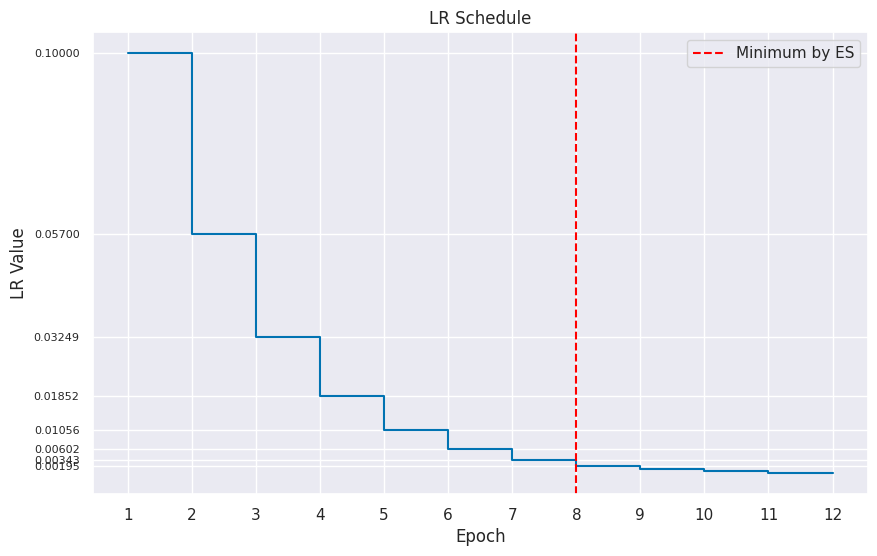

In [ ]:
# Epochs to display
n = 12
# Minimum number of epochs needed by Early Stopping schedule
min_early_stopping = PARAMETERS['EARLY_STOPPING']['start_from_epoch'] + PARAMETERS['EARLY_STOPPING']['patience']
# Number of steps within a epoch given the batch size
n_steps = np.ceil(train_samples / PARAMETERS["BATCH_SIZE"])
# Set the decay_steps argument to the number of steps in a epoch
PARAMETERS['LEARNING_RATE']['decay_steps'] = n_steps

# Set up Exponential scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(**PARAMETERS['LEARNING_RATE'])

# Compute LR schedule
lr_values = [lr_schedule(i * n_steps).numpy() for i in range(n)]

# Plot LR schedule
fig = plt.figure(figsize=(10, 6))
plt.step(x=range(1, n + 1), y=lr_values, where="post")
plt.axvline(x=min_early_stopping, color='red', linestyle='--', label='Minimum by ES')
plt.xlabel('Epoch')
plt.ylabel('LR Value')
plt.xticks(range(1, n + 1))
plt.yticks(lr_values[:8], fontsize= 8)
plt.title('LR Schedule')
plt.legend()
plt.show()

# Dataset Preprocessing

To avoid repeteadly preprocessing the input data each time we train the model I'll preprocess the data before training and turn off the preprocessing step with `preprocessing=False` argument.

In [ ]:
# Create preprocessing layers instances
user_prep = Preprocessing(name="UserPreprocessing", features=PARAMETERS['FEATURES']['USER'], ds=clicks.batch(512))
product_prep = Preprocessing(name="ProductPreprocessing", features=PARAMETERS['FEATURES']['PRODUCT'], ds=products.batch(512))
# Preprocess the entire clicks and products datasets
prep_clicks = clicks.batch(512).map(user_prep).map(product_prep).unbatch()
prep_products = products.batch(512).map(product_prep).unbatch()
# Preprocess the train and val datasets
prep_clicks_train = clicks_train.batch(512).map(user_prep).map(product_prep).unbatch()
prep_clicks_val = clicks_val.batch(512).map(user_prep).map(product_prep).unbatch()
# Preprocess the train and val shuffled datasets
prep_clicks_train_sh = clicks_train_sh.batch(512).map(user_prep).map(product_prep).unbatch()
prep_clicks_val_sh = clicks_val_sh.batch(512).map(user_prep).map(product_prep).unbatch()

## Baseline Model
The model selected to perform this analysis will be a baseline model that is as simple as possible to avoid overfitting, but complex enough that it doesn't fall into underfitting. Therefore, I will have disabled the cross layer and the deep layers in the retrieval model (only use one output layer to have the same output size in each tower).

Note I can't use KFold CV because the sequential features require to have the data ordered by timestamp.

In [ ]:
def train_baseline():
    params = copy.deepcopy(PARAMETERS)
    params['LOGDIR'] = os.path.join(LOGPATH, 'baseline')

    return train_model(
        train= clicks_train,
        val= clicks_val,
        preprocessing= True,
        params= params,
        train_metrics= True, # Turn on training metrics
        logging= True,
        profile= (20, 25) # enable profiling
    )

baseline = train_baseline()

Epoch 1/300


I0000 00:00:1733497045.151352     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


134/134 [==============================] - 52s 309ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0076 - factorized_top_k/top_5_categorical_accuracy: 0.0249 - factorized_top_k/top_10_categorical_accuracy: 0.0366 - factorized_top_k/top_50_categorical_accuracy: 0.0773 - factorized_top_k/top_100_categorical_accuracy: 0.1038 - root_mean_squared_error: 0.3394 - loss: 4603.6788 - regularization_loss: 0.0000e+00 - total_loss: 4603.6788 - val_factorized_top_k/top_1_categorical_accuracy: 0.0191 - val_factorized_top_k/top_5_categorical_accuracy: 0.0738 - val_factorized_top_k/top_10_categorical_accuracy: 0.1005 - val_factorized_top_k/top_50_categorical_accuracy: 0.1853 - val_factorized_top_k/top_100_categorical_accuracy: 0.2294 - val_root_mean_squared_error: 0.3181 - val_loss: 2966.6074 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2966.6074
Epoch 2/300
134/134 [==============================] - 29s 214ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0925 - factorized_t

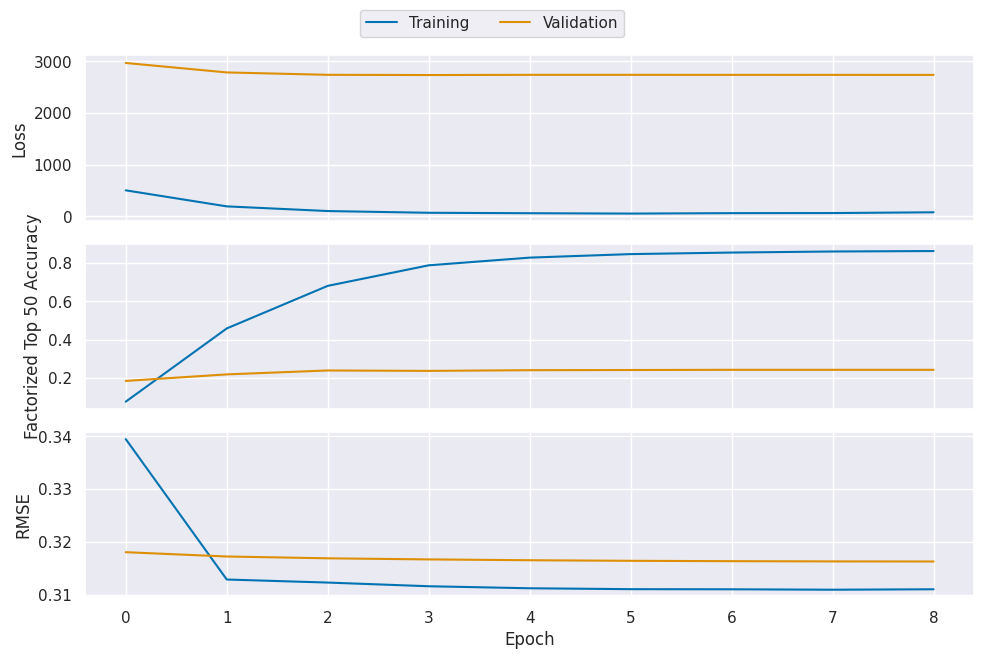

In [ ]:
baseline_results = pd.DataFrame(baseline.history.history)

def baseline_analysis(data: pd.DataFrame):
    """
    Function to plot generalization curves.
    """
    fig, ax = plt.subplots(3, 1, figsize=(10, 7), sharex=True)  # Adjusted figsize for better layout
    
    # Plot for total loss and validation loss
    data['total_loss'].plot(ax=ax[0], label='Training')
    data['val_total_loss'].plot(ax=ax[0], label='Validation')    
    ax[0].set_ylabel('Loss')

    # Plot for accuracy
    data[['factorized_top_k/top_50_categorical_accuracy', 'val_factorized_top_k/top_50_categorical_accuracy']].plot(ax=ax[1], legend=False)
    ax[1].set_ylabel('Factorized Top 50 Accuracy')
    
    # Plot for RMSE
    data[['root_mean_squared_error', 'val_root_mean_squared_error']].plot(ax=ax[2], legend=False)
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('RMSE')

    lines, labels = ax[0].get_legend_handles_labels()
    # Place the legend at the lower center
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=4)
    
    for a in ax:
        a.set_xticks(range(len(data)))
    # Adjust layout to make space for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

baseline_analysis(baseline_results)

The generalization curve, which plots the training and validation loss against epochs, shows that the loss becomes relatively stable after the second epoch. However, both accuracy and RMSE (Root Mean Square Error) continue to improve until the sixth epoch. This indicates that while the model is beginning to memorize the training data, it is still able to generalize effectively on the validation dataset.

It is important to note that the RMSE does not show any improvement throughout the training process. This suggests that the ranking model is struggling to learn how to accurately predict the product scores based on user feedback, which we defined as our target variable. The underlying issue appears to be the sparsity of user feedback data, which limits the model's ability to learn meaningful patterns.

To address this challenge, implementing resampling techniques may enhance the model's performance by providing a more balanced representation of the data. These techniques can help mitigate the effects of sparse feedback and improve the model's ability to learn from the available data.

## Batch Size

Let's figure out which batch size performs best.

In [ ]:
bse_path = os.path.join(LOGPATH, "batch_size_exp")
results_path = os.path.join(bse_path, "results.csv")

def batch_size_exp() -> None:
    """
    Function to perform batch size experimentation.
    """
    params = copy.deepcopy(PARAMETERS)
    # I won't use sequential features for this analysis in order to apply CV
    params['FEATURES']['USER'].remove("seq-seq_product_id")
    params['FEATURES']['USER'].remove("seq-seq_category_name")
    
    # Try different batch sizes
    batches = [32, 64, 128, 256, 512, 1024]
    results = []
    for i, batch in enumerate(batches):
        params['BATCH_SIZE'] = batch
        params['LOGDIR'] = os.path.join(bse_path, "bs_{}".format(params['BATCH_SIZE']))
        
        logging.info(f"Training model for {params['BATCH_SIZE']} batch size ({i+1}/{len(batches)})")
        init_time = time.time()
        results_df = train_CV(params)
        end_time = time.time()
        results_df['batch_size'] = batch
        results_df['training_time'] = end_time - init_time
        results.append(results_df)

    pd.concat(results, ignore_index= True).to_csv(results_path, index=False)
    logging.info(f"Saving results to {results_path}")
    return

batch_size_exp()

2024-12-06 15:02:03,993 - INFO - Training model for 32 batch size (1/6)


Cross Validation: 100%|██████████| 5/5 [07:53<00:00, 94.73s/fold]

2024-12-06 15:09:57,666 - INFO - Training model for 64 batch size (2/6)



Cross Validation: 100%|██████████| 5/5 [05:45<00:00, 69.16s/fold]

2024-12-06 15:15:43,499 - INFO - Training model for 128 batch size (3/6)



Cross Validation: 100%|██████████| 5/5 [04:54<00:00, 58.89s/fold]

2024-12-06 15:20:37,938 - INFO - Training model for 256 batch size (4/6)



Cross Validation: 100%|██████████| 5/5 [04:44<00:00, 56.93s/fold]

2024-12-06 15:25:22,600 - INFO - Training model for 512 batch size (5/6)



Cross Validation: 100%|██████████| 5/5 [04:28<00:00, 53.70s/fold]

2024-12-06 15:29:51,098 - INFO - Training model for 1024 batch size (6/6)



Cross Validation: 100%|██████████| 5/5 [04:14<00:00, 50.90s/fold]

2024-12-06 15:34:05,602 - INFO - Saving results to logs/batch_size_exp/results.csv


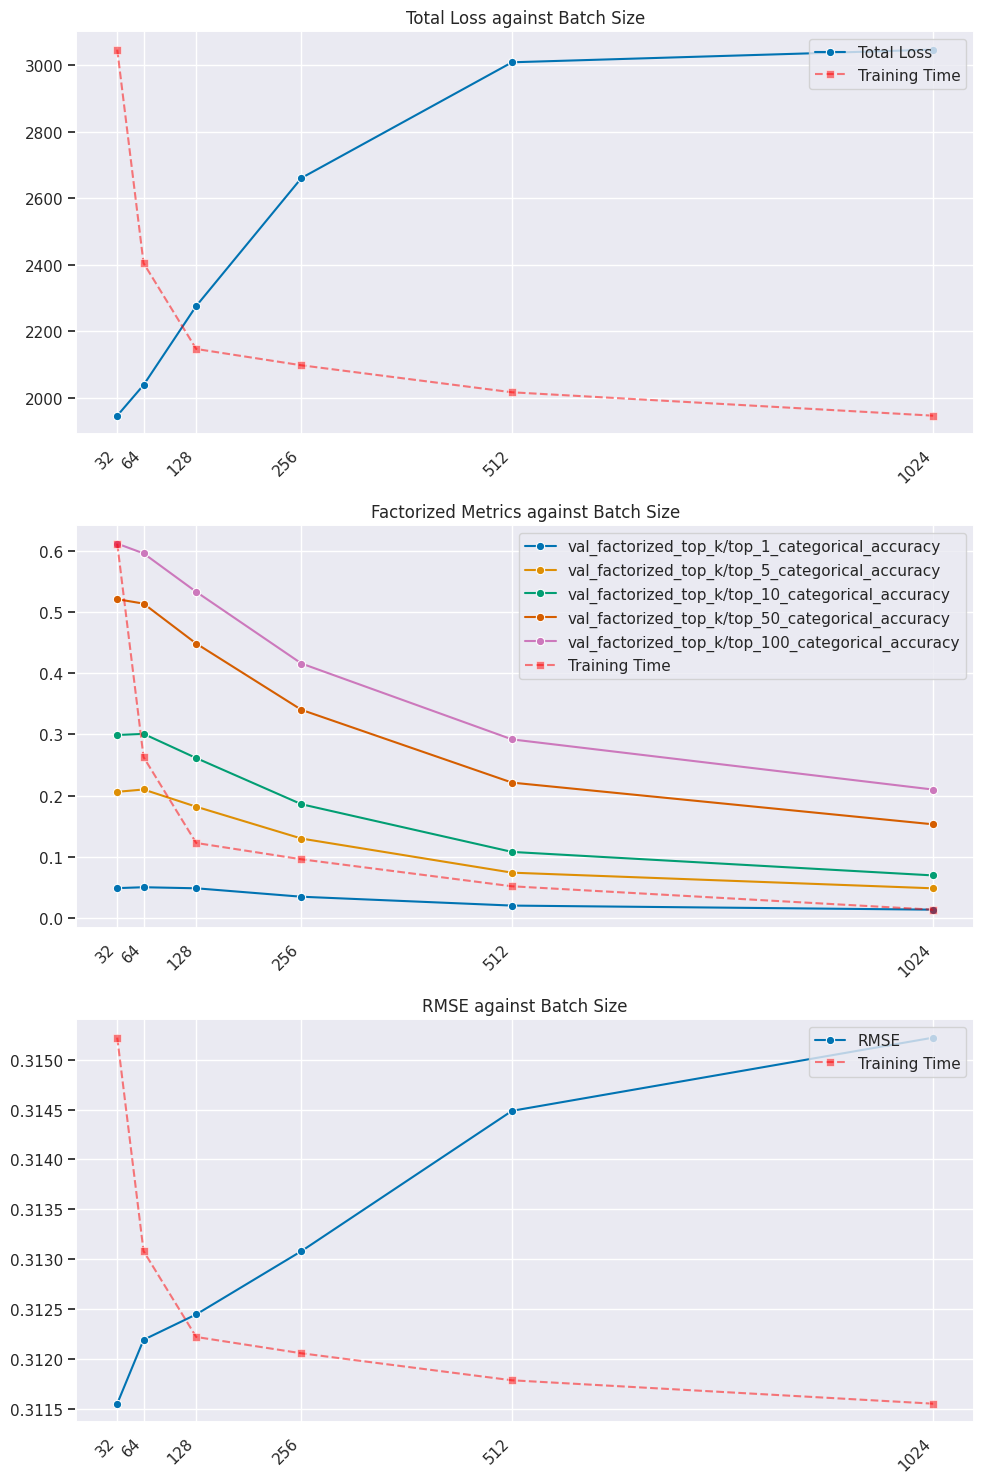

In [ ]:
results = pd.read_csv(results_path).groupby("batch_size").mean().reset_index()

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Total Loss against Batch Size Plot
sns.lineplot(data=results, x='batch_size', y='val_total_loss', marker='o', label="Total Loss", ax=axes[0])

# Factorized Top K Metrics against Batch Size Plot
for metric in [c for c in results.columns if c.startswith('val_factorized')]:
    sns.lineplot(data=results, x='batch_size', y=metric, marker='o', label=metric, ax=axes[1])

# RMSE against Batch Size Plot
sns.lineplot(data=results, x='batch_size', y='val_root_mean_squared_error', marker='o', label='RMSE', ax=axes[2])

# Add training time against batch size to each plot, removing label, ticks, and tick labels for twinx
for ax in axes:
    twin_ax = ax.twinx()
    sns.lineplot(
        data=results, x='batch_size', y='training_time', 
        linestyle='--', color='red', alpha=0.5,
        label='Training Time', 
        marker="s",ax=twin_ax, legend= False
    )
    
    # Remove the label and ticks for twinx
    twin_ax.set_ylabel('')           # Remove y-axis label for twinx
    twin_ax.set_yticks([])           # Remove y-axis ticks for twinx
    twin_ax.set_yticklabels([])      # Remove y-axis tick labels for twinx
    
    # Combine legends from both ax and twinx
    ax_handles, ax_labels = ax.get_legend_handles_labels()
    twin_handles, twin_labels = twin_ax.get_legend_handles_labels()
    ax.legend(ax_handles + twin_handles, ax_labels + twin_labels, loc='upper right')  # Combine legends

# Set titles
axes[0].set_title('Total Loss against Batch Size')
axes[1].set_title('Factorized Metrics against Batch Size')
axes[2].set_title('RMSE against Batch Size')

# Set labels and ticks
for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks(results['batch_size'])
    ax.set_xticklabels(results['batch_size'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

Batch size selection involves a well-known trade-off between accuracy and performance. Based on the results, a batch size of 64 appears to be the optimal choice in terms of minimizing training time while maintaining high precision.

In [ ]:
PARAMETERS['BATCH_SIZE'] = 64

## Forward Feature Selection

To identify the most impactful features while minimizing noise, I will gradually add features to the model, carefully logging the resulting metrics after each addition. I will start with a baseline which follows a standard matrix factorization model. User feature `user_id` and product feature `product_id` are the minimum required variables to develop a matrix factorization model. I will be adding side features looking for improvements.  

The sequence in which features are added is crucial, as it can significantly influence the features selected by the model. Running the process in a different order may lead to a different subset of features being chosen. This is due to the potential collinearity between features and the fact that adding a new feature doesn't always improve model performance—in some cases, it can even degrade accuracy.

In [ ]:
# Logging path
fs_path = os.path.join(LOGPATH, "feature_selection")

class FeatureSelection():
    def __init__(self, threshold: float = 0.05):
        self.threshold = threshold
        self.params = copy.deepcopy(PARAMETERS)
        # Reset the model features
        self.params['FEATURES']['USER'] = ["time", "score", "cat-user_id"]
        self.params['FEATURES']['PRODUCT'] = ["cat-product_id"]
        
        # Remove the initial user and product features
        self.model_user_features = [e for e in PARAMETERS['FEATURES']['USER'] if e not in self.params['FEATURES']['USER']]
        self.model_product_features = [e for e in PARAMETERS['FEATURES']['PRODUCT'] if e not in self.params['FEATURES']['PRODUCT']]

        # Array to save metrics for each model
        self.results = []

        # Set the order of features
        self.features = list(zip_longest(self.model_user_features, self.model_product_features))
        
        self.retrieval_metric_value = -np.inf
        self.rating_metric_value = np.inf    
    
    def train(self):
        """
        Add feature to the model, train it and return metrics.

        Parameters
        ----------
        parameters: dict
            Dictionary of parameters
        Returns
        -------
        dict
            History of the model
        """
        # Save logging
        model = train_model(
            train= prep_clicks_train,
            val= prep_clicks_val,
            preprocessing= False,
            params= self.params,
            logging= True,
            verbose= 0
        )
        result = {k: v[-1] for k, v in model.history.history.items() if k.startswith('val')}
        result['selected'] = False
        current_retrieval_value = result['val_factorized_top_k/top_50_categorical_accuracy']
        current_rating_value = result['val_root_mean_squared_error']

        # Keep the feature only if it improves one of the metrics and if both metrics don't exceed the threshold
        if (current_retrieval_value >= self.retrieval_metric_value or \
            current_rating_value <= self.rating_metric_value) and \
            (current_retrieval_value > self.retrieval_metric_value - self.threshold and \
            current_rating_value < self.rating_metric_value + self.threshold):
            self.retrieval_metric_value = current_retrieval_value
            self.rating_metric_value = current_rating_value
            result['selected'] = True # set flag to true if the feature will be added to the model
        return result

    def add_feature(self, tower: str, feature: str):
        self.params["FEATURES"][tower.upper()].append(feature)
        self.params["LOGDIR"] = os.path.join(fs_path, f"add_{tower}_{feature}")
        logging.info(f"Added {feature} feature to the {tower.capitalize()} Tower. Fitting...")
        result = self.train()
        if not result['selected']:
            logging.info(f"Feature named {feature} to {tower} tower doesn't improve the model.")
            self.params['FEATURES'][tower.upper()].remove(feature) # Remove feature from the parameters
        return {'tower': tower, 'feature': feature, **result}
    
    def fit(self):
        # Step by step, I will select one feature from user followed by one from product until all features are selected
        # Run the initial baseline model with only two features without adding any feature
        logging.info(f"Training baseline model")
        self.params["LOGDIR"] = os.path.join(fs_path, f"baseline")
        self.results.append({'tower': '', 'feature': 'baseline', **self.train()})

        for user_feature, product_feature in self.features:
            # Add a feature to the user, train the model and save result
            if user_feature:
                self.results.append(self.add_feature('user', user_feature))

            # Add a feature to the product, train the model and save result
            if product_feature:
                self.results.append(self.add_feature('product', product_feature))
        
        # Save results for further analysis
        results_df = pd.DataFrame(self.results)
        results_path = os.path.join(fs_path, "results.csv")
        logging.info(f"Saving results to {results_path}")
        results_df.to_csv(results_path, index_label="run_number")

# FeatureSelection().fit()

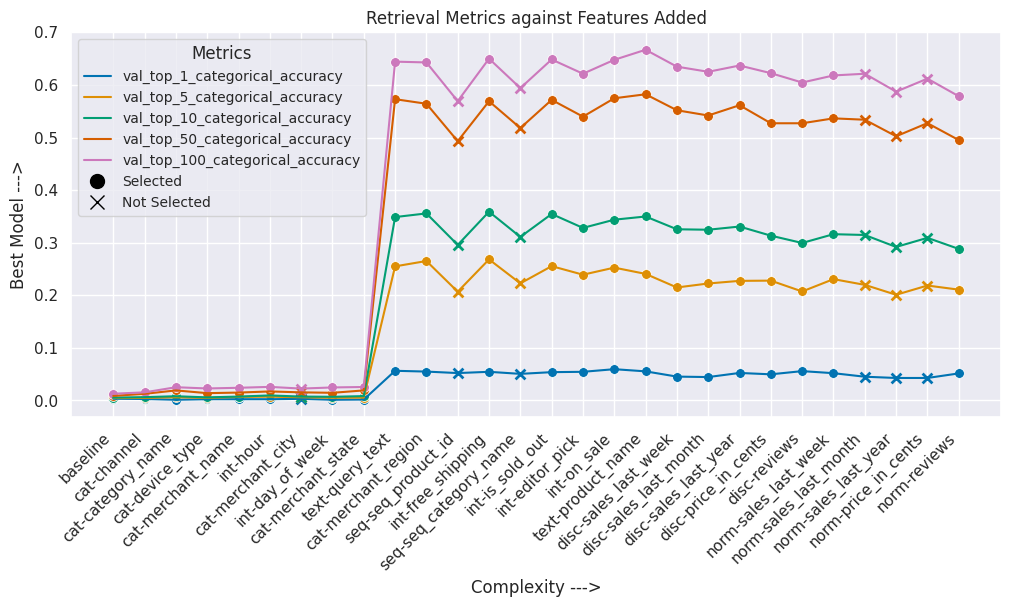

In [ ]:
# Read results from Feature Selection
results = pd.read_csv(os.path.join(fs_path, "results.csv"))

def fs_plot(values: list):
    # Plot Retrieval Metrics against Features Added
    fig = plt.figure(figsize=(12, 5))

    for value in values:
        line_plot = sns.lineplot(data=results, x='feature', y=value, label= value, markers=True)
        line_color = line_plot.get_lines()[-1].get_color()
        sns.scatterplot(data=results[results['selected']], x='feature', y=value, marker='o', color=line_color, s=50)
        sns.scatterplot(data=results[~results['selected']], x='feature', y=value, marker='x', color=line_color, s=50, linewidth=2)

    legend_elements = [
            Line2D([0], [0], color='black', marker='o', markersize=10, 
                              label='Selected', linestyle='None', linewidth=2),
        Line2D([0], [0], color='black', marker='x', markersize=10, 
                              label='Not Selected', linestyle='None', linewidth=2)
    ]

    # Add the default legend for lines, and then the manual marker legend
    plt.legend(
        title='Metrics', 
        handles=plt.gca().get_legend().legend_handles + legend_elements,
        fontsize= 10
    )
    plt.xticks(rotation=45, ha= 'right')
    plt.xlabel('Complexity --->')
    return fig

results.columns = [col.replace('val_factorized_top_k/', 'val_') for col in results.columns]
plot = fs_plot(values = [c for c in results.columns if c.startswith('val_top')])
plt.title('Retrieval Metrics against Features Added')
plt.ylabel('Best Model --->')
plt.show()

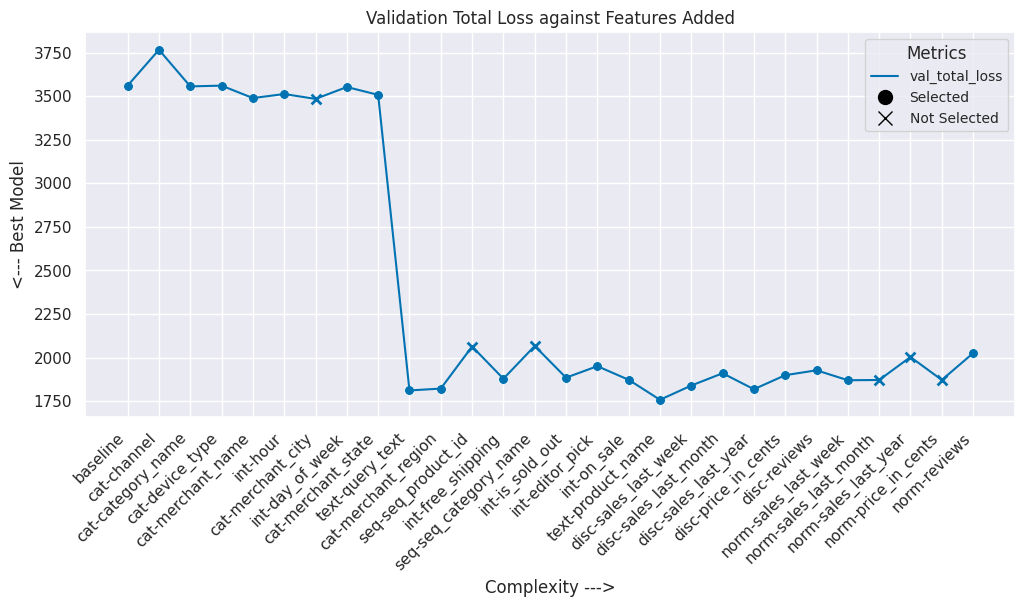

In [ ]:
plot = fs_plot(values = ['val_total_loss'])

plt.title('Validation Total Loss against Features Added')
plt.ylabel('<--- Best Model')
plt.show()

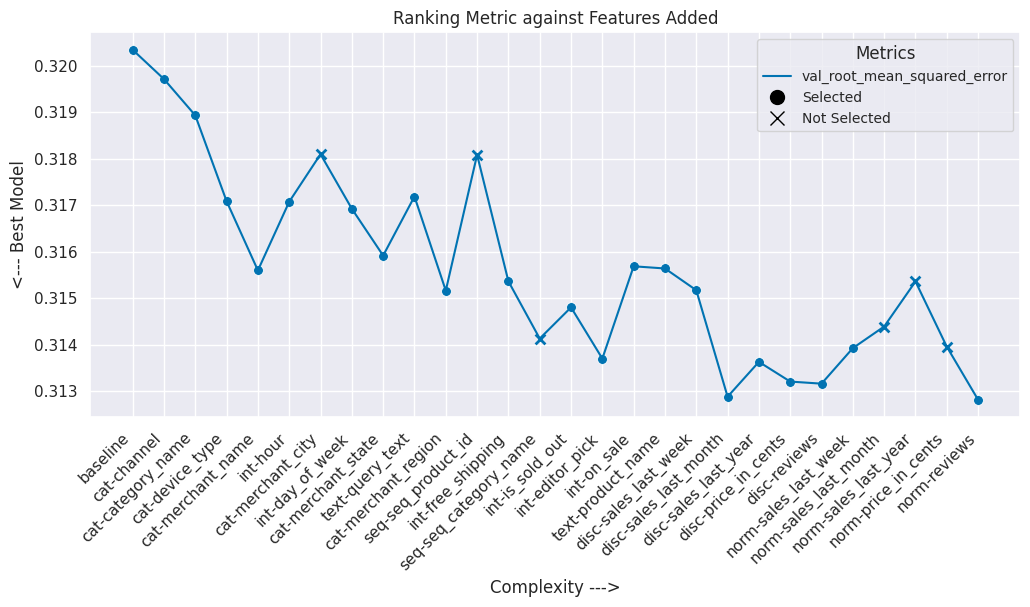

In [ ]:
plot = fs_plot(values = ['val_root_mean_squared_error'])

plt.title('Ranking Metric against Features Added')
plt.ylabel('<--- Best Model')
plt.show()

Based on the results obtained, the following features demonstrate a decrease in accuracy when included in the model:

In [ ]:
not_selected_features = results[results['selected'] == False]['feature'].tolist()

Sequential features, `seq_product_id` and `seq_category_name`, show limited utility, as only 20% of users have recorded multiple clicks. Thus, including this sequential data as a feature does not provide significant value. By excluding sequential features, I am now able to work with shuffled versions of the training and validation datasets, which may further simplify the model.

In [ ]:
PARAMETERS['FEATURES']['USER'] = [f for f in PARAMETERS['FEATURES']['USER'] if f not in not_selected_features]
PARAMETERS['FEATURES']['PRODUCT'] = [f for f in PARAMETERS['FEATURES']['PRODUCT'] if f not in not_selected_features]
pprint.pprint(PARAMETERS['FEATURES'])

{'PRODUCT': ['cat-product_id',
             'cat-category_name',
             'cat-merchant_name',
             'cat-merchant_state',
             'cat-merchant_region',
             'int-free_shipping',
             'int-is_sold_out',
             'int-editor_pick',
             'int-on_sale',
             'text-product_name',
             'disc-sales_last_week',
             'disc-sales_last_month',
             'disc-sales_last_year',
             'disc-price_in_cents',
             'disc-reviews',
             'norm-sales_last_week',
             'norm-reviews'],
 'USER': ['time',
          'cat-user_id',
          'cat-channel',
          'cat-device_type',
          'int-hour',
          'int-day_of_week',
          'text-query_text',
          'score']}


## Deep Retrieval Experiment
Test if it is worth to use deep layers in my retrieval model given the available data.

In [ ]:
dl_path = os.path.join(LOGPATH, 'deep_layers_exp')

def deep_layers_exp():
    params = copy.deepcopy(PARAMETERS)
    # Try different architectures from 0 to 2 deep layers
    deep_layers = [[32], [64, 32], [128, 63, 32]]

    results = []
    for layers in deep_layers:
        # Use the number of layers as ID of each model
        n_layers = len(layers) - 1
        logging.info(f"Training model with the following layers: \n- User Layers: {layers} \n- Product Layers: {layers}\n")
        params['LOGDIR'] = os.path.join(dl_path, f'{n_layers}_deep_layers')
        # Update layers architecture for each tower
        params['MODEL']['user_layers'] = layers
        params['MODEL']['product_layers'] = layers
        
        result = train_CV(params)
        result['n_layers'] = n_layers
        results.append(result)

    results_df = pd.concat(results, ignore_index= True)
    results_path = os.path.join(dl_path, 'cv_results.csv')
    logging.info(f"Saving results to {results_path}")
    results_df.to_csv(results_path, index=False)

deep_layers_exp()

2024-12-06 15:34:16,350 - INFO - Training model with the following layers: 
- User Layers: [32] 
- Product Layers: [32]



Cross Validation: 100%|██████████| 5/5 [05:42<00:00, 68.56s/fold]

2024-12-06 15:39:59,160 - INFO - Training model with the following layers: 
- User Layers: [64, 32] 
- Product Layers: [64, 32]




Cross Validation: 100%|██████████| 5/5 [06:02<00:00, 72.45s/fold]

2024-12-06 15:46:01,442 - INFO - Training model with the following layers: 
- User Layers: [128, 63, 32] 
- Product Layers: [128, 63, 32]




Cross Validation: 100%|██████████| 5/5 [06:09<00:00, 73.94s/fold]

2024-12-06 15:52:11,150 - INFO - Saving results to logs/deep_layers_exp/cv_results.csv


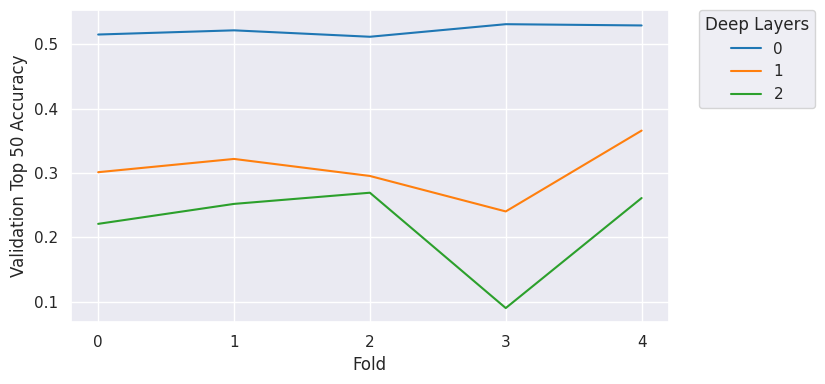

In [ ]:
results_df = pd.read_csv(os.path.join(dl_path, 'cv_results.csv'))

fig = plt.figure(figsize=(10, 4))

palette = ["#1f77b4", "#ff7f0e", "#2ca02c"]
# Plot the retrieval metric against folds
sns.lineplot(
    x='fold', 
    y='val_factorized_top_k/top_50_categorical_accuracy', 
    hue='n_layers', 
    data=results_df, 
    palette= palette
)
plt.xlabel("Fold")
plt.ylabel("Validation Top 50 Accuracy")
plt.xticks(range(0, 5))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Deep Layers')
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for the legend
plt.show()

Note we are focusing solely on analyzing the retrieval metrics, as the deep layers in this context impact only the retrieval model.

Based on the results, the retrieval accuracy decreases when deeper layers are added to both towers of the model. Therefore, I will exclude deep layers from the current implementation to maintain performance. However, these deeper layers will be highly beneficial and strongly recommended as the dataset size increases, allowing the model to better leverage its capacity to learn more complex patterns.

### Resampling
After experimenting with the model, I observed that the **RMSE** metric along the *rating model* showed no improvement. Given the sparsity of my dataset, I plan to address this issue by applying resampling techniques to balance the data, specifically focusing on the `score` feature, which serves as the target variable.

The `score` feature exhibits significant skewness, which could be contributing to the model's poor performance. To mitigate this, I will utilize the *ImbalancedLearningRegression* package, implementing various resampling strategies. The goal is to redistribute the data more evenly across the range of `score` values, thus reducing the imbalance and potentially enhancing the model’s predictive accuracy.

By balancing the dataset through resampling, I aim to improve the RMSE metric and overall performance of the ranking task.

Reference:  
*Wu, W., Kunz, N., & Branco, P. (2022, September). ImbalancedLearningRegression-A Python Package to Tackle the Imbalanced Regression Problem. In Joint European Conference on Machine Learning and Knowledge Discovery in Databases (pp. 645-648). Cham: Springer Nature Switzerland.*

In [ ]:
def resample(data: pd.DataFrame):
    # The rel_ctrl_pts_rg argument takes a 2d array (matrix). 
    # It is used to manually specify the regions of interest or rare "minority" values in y. 
    # The first column indicates the y values of interest, the second column indicates a mapped value of relevance, either 0 or 1, 
    # where 0 is the least relevant and 1 is the most relevant, and the third column is indicative. 
    # It will be adjusted afterwards, use 0 in most cases.
    rg_matrix = [
        [0.5, 1, 0], # minority class, high relevance
        [1.0, 1, 0], # minority class, high relevance
        [0, 0, 0] # majority class, low relevance
    ]

    # Random Oversample
    logging.info("Random Oversample")
    ro_clicks_train_df = iblr.ro(
        data = data,
        y = 'score',
        rel_method="manual", # Set manual to use manual relevance control
        rel_ctrl_pts_rg= rg_matrix # Set relevance control points
    )

    # Random Undersampling
    logging.info("Random Undersampling")
    ru_clicks_train_df = iblr.random_under(
        data = data,
        y = 'score',
        rel_method="manual",
        rel_ctrl_pts_rg= rg_matrix
    )

    # Gaussian Noise
    logging.info("Gaussian Noise")
    gn_clicks_train_df = iblr.gn(
        data = data,
        y = 'score',
        rel_method="manual",
        rel_ctrl_pts_rg= rg_matrix
    )

    # Print shapes
    print(f"Original shape: {data.shape}")
    print(f"RO shape: {ro_clicks_train_df.shape}")
    print(f"RU shape: {ru_clicks_train_df.shape}")
    print(f"Gaussian Noise shape: {gn_clicks_train_df.shape}")

    # Load as dataset
    logging.info("Load as dataset")
    features = [f for f in user_features + product_features if not f.startswith("seq")]
    orig_clicks_train = create_dataset(data, features)
    ro_clicks_train = create_dataset(ro_clicks_train_df, features)
    ru_clicks_train = create_dataset(ru_clicks_train_df, features)
    gn_clicks_train = create_dataset(gn_clicks_train_df, features)

    # Plot densities
    ro_clicks_train_df['score'].plot(kind="kde", label="Random Oversampling", title="Resampling Comparison")
    ru_clicks_train_df['score'].plot(kind="kde", label="Random Undersampling")
    gn_clicks_train_df['score'].plot(kind="kde", label="Gaussian Noise")
    data['score'].plot(kind="kde", label="Original")
    plt.xlabel("Score")
    plt.xticks([0, 0.5, 1])
    plt.legend()
    plt.show()

    return orig_clicks_train, ro_clicks_train, ru_clicks_train, gn_clicks_train

2024-12-06 15:52:14,323 - INFO - Resample training
2024-12-06 15:52:14,334 - INFO - Random Oversample


r_index: 100%|##########| 5480/5480 [00:02<00:00, 2010.79it/s]


2024-12-06 15:52:27,341 - INFO - Random Undersampling


new_index: 100%|##########| 8568/8568 [00:03<00:00, 2280.43it/s]


2024-12-06 15:53:15,531 - INFO - Gaussian Noise


r_index: 100%|##########| 2392/2392 [00:33<00:00, 70.83it/s]


Original shape: (17136, 28)
RO shape: (22616, 28)
RU shape: (11656, 28)
Gaussian Noise shape: (17136, 28)
2024-12-06 15:54:42,856 - INFO - Load as dataset


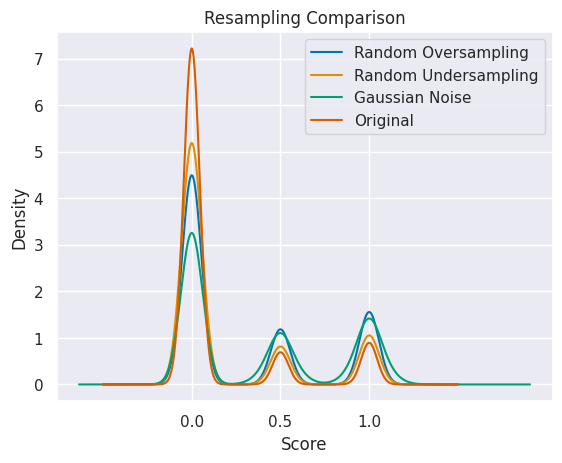

2024-12-06 15:54:44,448 - INFO - Training model for original dataset (1/4)
2024-12-06 15:55:50,321 - INFO - Training model for RO dataset (2/4)
2024-12-06 15:57:13,965 - INFO - Training model for RU dataset (3/4)
2024-12-06 15:58:18,857 - INFO - Training model for GN dataset (4/4)
2024-12-06 15:59:25,490 - INFO - Saving results to logs/resample/results.csv


In [ ]:
resample_path = os.path.join(LOGPATH, "resample")

def resample_training():
    params = copy.deepcopy(PARAMETERS)
    
    logging.info("Resample training")

    # Sequential features aren't accepted by the resampling methods.
    original_clicks_train_df = clicks_train_df_sh.drop(['seq_product_id', 'seq_category_name'], axis=1).reset_index(drop=True)  # Has to be a pandas dataframe

    orig_clicks_train, ro_clicks_train, ru_clicks_train, gn_clicks_train = resample(original_clicks_train_df)
    # list of tf datasets
    train_sets = [orig_clicks_train, ro_clicks_train, ru_clicks_train, gn_clicks_train]
    train_names = ["original", "RO", "RU", "GN"]

    results = []
    for i, (train, name) in enumerate(zip(train_sets, train_names)):
        params['LOGDIR'] = os.path.join(resample_path, name)
        logging.info(f"Training model for {name} dataset ({i+1}/{len(train_sets)})")
        model = train_model(
            train = train,
            val = clicks_val_sh,
            preprocessing= True,
            params= params,
            logging=True,
            verbose= 0
        )
        result = {k: v[-1] for k, v in model.history.history.items() if k.startswith('val')}
        results.append({'name': name, **result})

    results_path = os.path.join(resample_path, "results.csv")
    logging.info("Saving results to " + results_path)
    pd.DataFrame(results).to_csv(results_path, index=False)

# Uncomment to run
resample_training()

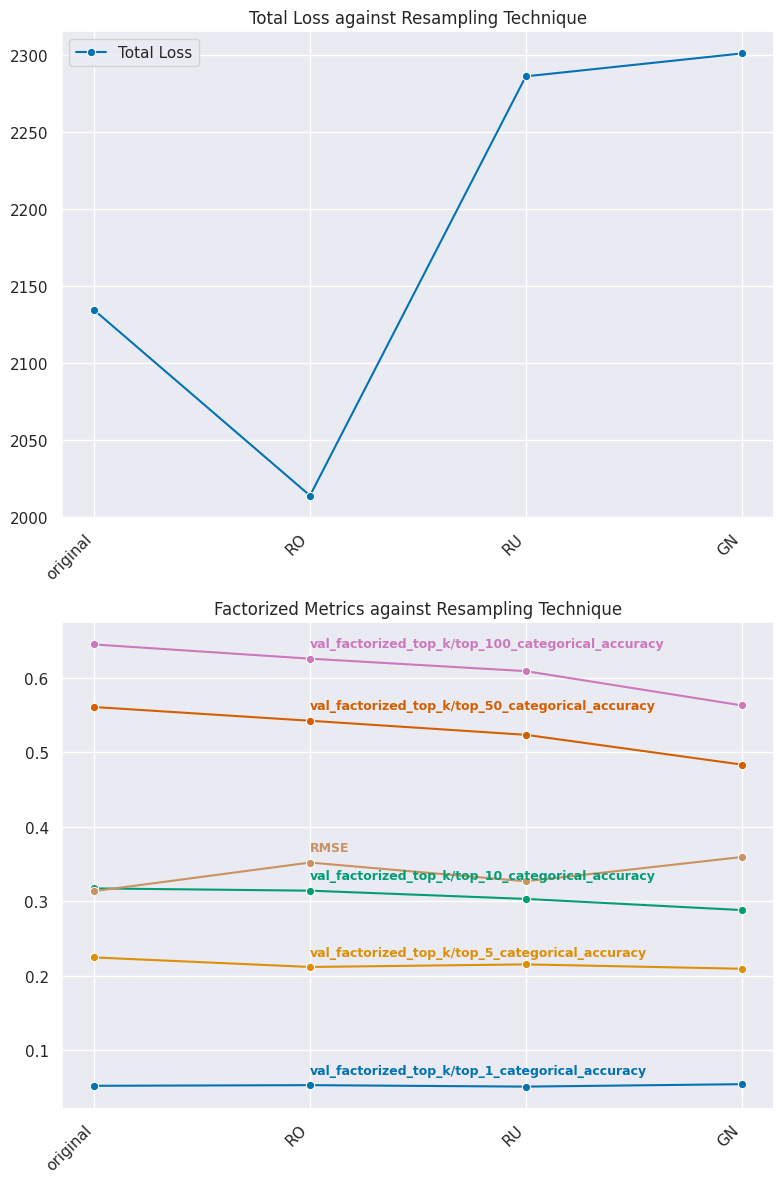

In [ ]:
results = pd.read_csv(os.path.join(resample_path, "results.csv"))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))

# Total Loss against Batch Size Plot
sns.lineplot(data=results, x='name', y='val_total_loss', marker='o', label="Total Loss", ax=axes[0])

# Factorized Top K Metrics against Batch Size Plot
retrieval_metrics = [c for c in results.columns if c.startswith('val_factorized')]
for metric in retrieval_metrics:
    sns.lineplot(data=results, x='name', y=metric, marker='o', label=metric, ax=axes[1])

# RMSE against Batch Size Plot
sns.lineplot(data=results, x='name', y='val_root_mean_squared_error', marker='o', label='RMSE', ax=axes[1])

# Set titles
axes[0].set_title('Total Loss against Resampling Technique')
axes[1].set_title('Factorized Metrics against Resampling Technique')

# Set labels and ticks
for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks(results['name'])
    ax.set_xticklabels(results['name'], rotation=45, ha='right')

# Place labels directly over the lines
for line, label in zip(plt.gca().get_lines(), retrieval_metrics + ['RMSE']):
    x = line.get_xdata()[1]
    y = line.get_ydata()[1] + 0.02
    
    plt.text(x, y, label, color=line.get_color(), fontweight='bold', va='center', fontsize= 9)    

plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

**Conclusion**: The resampling techniques applied did not result in a significant improvement over the original dataset. The ranking model's performance remained largely unchanged, suggesting that the model may be limited by the inherent sparsity and lack of sufficient data. This could indicate that the model has already extracted most of the learnable patterns from the data, and further improvements may require either more comprehensive data or a different modeling approach.